# Libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from pprint import pprint

from src.utils import (
    # Old utils
    print_h, eval_window, eval_person_majority_voting,

    # New utils
    set_seed, get_device, init_metrics, update_metrics, save_metrics_to_json,
    plot_k_fold_roc_curves_multiclass_v2, plot_k_fold_cm,
)
from src.models import RNNInceptionTime, HardMoE

/home/mitlab/miniconda3/envs/alxxtexxr_py312_torch22/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
# Project config
seed = 69
set_seed(seed)
device = get_device()
print("Device:", device)

# Data and model config
# ================================
# K-FOLD: 10
# ================================
k_fold_dir_map = {
    'Ga': 'data/preprocessed/Ga_k10_w500_s500_v20250501004633',
    'Ju': 'data/preprocessed/Ju_k10_w500_s500_w_anomaly_v20250501004735',
    'Si': 'data/preprocessed/Si_k10_w500_s250_w_anomaly_v20250501004847',
}
expert_model_dir_map = {
    'Ga': 'checkpoints/RNNInceptionTime_bidirectional_Ga_k10_w500_s500_e20_v20250520224322',
    'Ju': 'checkpoints/RNNInceptionTime_bidirectional_Ju_k10_w500_s500_w_anomaly_e5_v20250529001340',
    'Si': 'checkpoints/RNNInceptionTime_bidirectional_Si_k10_w500_s250_w_anomaly_e30_v20250529213629',
}
gate_model_dir = 'checkpoints/RNNInceptionTimeGate_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20_v20250531134835'

# ================================
# K-FOLD: 5
# ================================
# k_fold_dir_map = {
#     'Ga': 'data/preprocessed/Ga_k5_w500_s500_v20250523145245',
#     'Ju': 'data/preprocessed/Ju_k5_w500_s500_w_anomaly_v20250602191302',
#     'Si': 'data/preprocessed/Si_k5_w500_s500_w_anomaly_v20250602191526',
# }
# expert_model_dir_map = {
#     'Ga': 'checkpoints/RNNInceptionTime_bidirectional_Ga_k5_w500_s500_e20_v20250523150148',
#     'Ju': 'checkpoints/RNNInceptionTime_bidirectional_Ju_k5_w500_s500_w_anomaly_e5_v20250602191942',
#     'Si': 'checkpoints/RNNInceptionTime_bidirectional_Si_k5_w500_s500_w_anomaly_e30_v20250602192252',
# }
# gate_model_dir = 'checkpoints/RNNInceptionTimeGate_bidirectional_Ga_k5_w500_s500_Ju_k5_w500_s500_w_anomaly_Si_k5_w500_s500_w_anomaly_e20_v20250602235553'

# ================================
# K-FOLD: 3
# ================================
# k_fold_dir_map = {
#     'Ga': 'data/preprocessed/Ga_k3_w500_s500_v20250523145118',
#     'Ju': 'data/preprocessed/Ju_k3_w500_s500_w_anomaly_v20250602191346',
#     'Si': 'data/preprocessed/Si_k3_w500_s500_w_anomaly_v20250602191610',
# }
# expert_model_dir_map = {
#     'Ga': 'checkpoints/RNNInceptionTime_bidirectional_Ga_k3_w500_s500_e20_v20250523150158',
#     'Ju': 'checkpoints/RNNInceptionTime_bidirectional_Ju_k3_w500_s500_w_anomaly_e5_v20250602192112',
#     'Si': 'checkpoints/RNNInceptionTime_bidirectional_Si_k3_w500_s500_w_anomaly_e30_v20250602192348',
# }
# gate_model_dir = 'checkpoints/RNNInceptionTimeGate_bidirectional_Ga_k3_w500_s500_Ju_k3_w500_s500_w_anomaly_Si_k3_w500_s500_w_anomaly_e20_v20250602235627'

# Evaluation config
batch_size = 8
n_feat = 16
n_class = 4
window_size = 500
max_vgrf_data_len = 25_000

general_metrics_dir = 'evaluations/RNNInceptionTimeMoE_' + gate_model_dir.rsplit('RNNInceptionTimeGate_')[-1].split('_v')[0] + '/_general_metrics'
cm_dir = 'evaluations/RNNInceptionTimeMoE_' + gate_model_dir.rsplit('RNNInceptionTimeGate_')[-1].split('_v')[0] + '/cm'
roc_curves_dir = 'evaluations/RNNInceptionTimeMoE_' + gate_model_dir.rsplit('RNNInceptionTimeGate_')[-1].split('_v')[0] + '/roc_curves'
print("Evaluation general metrics save directory:", general_metrics_dir)
print("Evaluation confusion matrix save directory:", cm_dir)
print("Evaluation ROC curves save directory:", roc_curves_dir)

2025-06-09 15:12:56.678486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 15:12:56.698924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 15:12:56.705526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 15:12:56.721357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 15:12:57.682715: W tensorflow/compiler/tf2

Random seed: 69
Device: cuda
Evaluation general metrics save directory: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/_general_metrics
Evaluation confusion matrix save directory: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/cm
Evaluation ROC curves save directory: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/roc_curves


# Evaluation

In [3]:
import pickle

moe_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'eval_time_avg', 'eval_time_list', 'cm', 
                            'fpr_multiclass_list', 'tpr_multiclass_list', 'roc_auc_multiclass_list', 'roc_auc_multiclass_avg'])
gate_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm'])
expert_metrics = {
    'Ga': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Ju': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Si': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
}

study_label_map = {
    'Ga': 0,
    'Ju': 1,
    'Si': 2,
}

for fold_i_dir_name in sorted(os.listdir(k_fold_dir_map['Ga'])):
    # ================================================================================================================================
    # FOLD
    # ================================================================================================================================
    print_h(fold_i_dir_name, 128)

    # TEMP: Make a directory for dataset pickels
    np_datasets_pkl_save_dir = '__MODELS_DATASETS__/np_datasets_pkl/' + fold_i_dir_name
    os.makedirs(np_datasets_pkl_save_dir, exist_ok=True)

    np_datasets_v2_pkl_save_dir = '__MODELS_DATASETS__/np_datasets_v2_pkl/' + fold_i_dir_name
    os.makedirs(np_datasets_v2_pkl_save_dir, exist_ok=True)

    # TEMP: Make a directory for dataset .npy files
    np_datasets_npy_save_dir = '__MODELS_DATASETS__/np_datasets_npy/' + fold_i_dir_name
    os.makedirs(np_datasets_npy_save_dir, exist_ok=True)

    np_datasets_v2_npy_save_dir = '__MODELS_DATASETS__/np_datasets_v2_npy/' + fold_i_dir_name
    os.makedirs(np_datasets_v2_npy_save_dir, exist_ok=True)
    
    expert_model_map = {
        'Ga': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
        'Ju': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
        'Si': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
    }

    X_train_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_train_window_GaJuSi = torch.empty(0).long()
    study_labels_train_window_GaJuSi = torch.empty(0).long()
    
    X_val_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_val_window_GaJuSi = torch.empty(0).long()
    study_labels_val_window_GaJuSi = torch.empty(0).long()

    X_test_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_test_window_GaJuSi = torch.empty(0).long()
    study_labels_test_window_GaJuSi = torch.empty(0).long()

    X_val_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
    y_val_person_GaJuSi = torch.empty(0).long()
    # study_labels_val_person_GaJuSi = torch.empty(0).long()

    X_test_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
    y_test_person_GaJuSi = torch.empty(0).long()
    # study_labels_test_person_GaJuSi = torch.empty(0).long()

    for study, k_fold_dir in k_fold_dir_map.items():
        # ================================================================================================
        # EXPERT MODEL
        # ================================================================================================
        print_h(f"EXPERT-{study} MODEL", 96)

        fold_i_dir = os.path.join(k_fold_dir, fold_i_dir_name)

        X_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_train_window.npy'))).float()
        y_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_train_window.npy'))).long()
        study_labels_train_window = torch.tensor([study_label_map[study]] * len(y_train_window)).long()
        X_train_window_GaJuSi = torch.cat((X_train_window_GaJuSi, X_train_window), dim=0)
        y_train_window_GaJuSi = torch.cat((y_train_window_GaJuSi, y_train_window), dim=0)
        study_labels_train_window_GaJuSi = torch.cat((study_labels_train_window_GaJuSi, study_labels_train_window), dim=0)

        X_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_window.npy'))).float()
        y_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_window.npy'))).long()
        study_labels_val_window = torch.tensor([study_label_map[study]] * len(y_val_window)).long()
        X_val_window_GaJuSi = torch.cat((X_val_window_GaJuSi, X_val_window), dim=0)
        y_val_window_GaJuSi = torch.cat((y_val_window_GaJuSi, y_val_window), dim=0)
        study_labels_val_window_GaJuSi = torch.cat((study_labels_val_window_GaJuSi, study_labels_val_window), dim=0)

        X_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_window.npy'))).float()
        y_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_window.npy'))).long()
        study_labels_test_window = torch.tensor([study_label_map[study]] * len(y_test_window)).long()
        X_test_window_GaJuSi = torch.cat((X_test_window_GaJuSi, X_test_window), dim=0)
        y_test_window_GaJuSi = torch.cat((y_test_window_GaJuSi, y_test_window), dim=0)
        study_labels_test_window_GaJuSi = torch.cat((study_labels_test_window_GaJuSi, study_labels_test_window), dim=0)

        X_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_person.npy'))).float()
        y_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_person.npy'))).long()
        X_val_person_GaJuSi = torch.cat((X_val_person_GaJuSi, X_val_person), dim=0)
        y_val_person_GaJuSi = torch.cat((y_val_person_GaJuSi, y_val_person), dim=0)

        X_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_person.npy'))).float()
        y_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_person.npy'))).long()
        X_test_person_GaJuSi = torch.cat((X_test_person_GaJuSi, X_test_person), dim=0)
        y_test_person_GaJuSi = torch.cat((y_test_person_GaJuSi, y_test_person), dim=0)

        # TEMP: Save dataset pickels for each source study
        with open(np_datasets_pkl_save_dir + f'/X_test_person_{study}.pkl', 'wb') as f:
            pickle.dump(X_test_person, f)
        
        with open(np_datasets_pkl_save_dir + f'/y_test_person_{study}.pkl', 'wb') as f:
            pickle.dump(y_test_person, f)

        # TEMP: Save dataset .npy files for each source study
        np.save(np_datasets_npy_save_dir + f'/X_test_person_{study}.npy', X_test_person)
        np.save(np_datasets_npy_save_dir + f'/y_test_person_{study}.npy', y_test_person)

        train_window_dataset = TensorDataset(X_train_window, y_train_window)
        val_window_dataset = TensorDataset(X_val_window, y_val_window)
        test_window_dataset = TensorDataset(X_test_window, y_test_window)
        
        val_person_dataset = TensorDataset(X_val_person, y_val_person)
        test_person_dataset = TensorDataset(X_test_person, y_test_person)

        train_dataloader = DataLoader(train_window_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_window_dataset, batch_size=batch_size, shuffle=False)
        test_dataloader = DataLoader(test_window_dataset, batch_size=batch_size, shuffle=False)
        
        expert_model = expert_model_map[study]

        # Load pretrained expert model
        model_i_path = os.path.join(expert_model_dir_map[study], fold_i_dir_name + '.pth')
        expert_model.load_state_dict(torch.load(model_i_path, map_location=device))

        # ================================================================
        # EXPERT MODEL EVALUATION ON PERSON DATA BY MAJORITY VOTING
        # ================================================================
        print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
        (
            _, 
            acc_person_majority_voting, 
            f1_person_majority_voting, 
            precision_person_majority_voting, 
            recall_person_majority_voting, 
            cm_person_majority_voting, 
            *_
        ) = eval_person_majority_voting(
            expert_model, 
            test_person_dataset, 
            criterion=None, 
            average='weighted',
            window_size=window_size, 
            debug=False,
            seed=seed,
        )
        print("acc:", acc_person_majority_voting)
        print("f1:", f1_person_majority_voting)
        print("precision:", precision_person_majority_voting)
        print("recall:", recall_person_majority_voting)
        print("cm:\n", np.array(cm_person_majority_voting))
        print()

        expert_metrics[study] = update_metrics(expert_metrics[study], {
            'acc': acc_person_majority_voting,
            'f1': f1_person_majority_voting,
            'precision': precision_person_majority_voting,
            'recall': recall_person_majority_voting,
            'cm': cm_person_majority_voting,
        })

    # ================================================================================================
    # GATE MODEL
    # ================================================================================================
    print_h("GATE MODEL", 96)

    # train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, y_train_window_GaJuSi)
    # val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, y_val_window_GaJuSi)
    # test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, y_test_window_GaJuSi)

    train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, study_labels_train_window_GaJuSi)
    val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, study_labels_val_window_GaJuSi)
    test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, study_labels_test_window_GaJuSi)

    train_dataloader_GaJuSi = DataLoader(train_window_dataset_GaJuSi, batch_size=batch_size, shuffle=True)
    val_dataloader_GaJuSi = DataLoader(val_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)
    test_dataloader_GaJuSi = DataLoader(test_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)

    gate_model = RNNInceptionTime(c_in=n_feat, c_out=len(study_label_map.keys()), seq_len=window_size, bidirectional=True).to(device)

    # Load pretrained gate model
    gate_model_i_path = os.path.join(gate_model_dir, fold_i_dir_name + '.pth')
    gate_model.load_state_dict(torch.load(gate_model_i_path, map_location=device))

    print_h("EVALUATION ON WINDOW DATA", 64)
    
    _, acc_window, f1_window, precision_window, recall_window, cm_window = eval_window(gate_model, test_dataloader_GaJuSi, average='weighted')

    print("acc:", acc_window)
    print("f1:", f1_window)
    print("precision:", precision_window)
    print("recall:", recall_window)
    print("cm:\n", np.array(cm_window))
    print()

    gate_metrics = update_metrics(gate_metrics, {
        'acc': acc_window,
        'f1': f1_window,
        'precision': precision_window,
        'recall': recall_window,
        'cm': cm_window,
    })

    # ================================================================================================
    # MoE MODEL
    # ================================================================================================
    print_h("MoE MODEL", 96)

    val_person_dataset_GaJuSi = TensorDataset(X_val_person_GaJuSi, y_val_person_GaJuSi)
    test_person_dataset_GaJuSi = TensorDataset(X_test_person_GaJuSi, y_test_person_GaJuSi)

    moe_model = HardMoE(experts=expert_model_map.values(), gate=gate_model).to(device)

    print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
    (
        _, 
        acc_person_majority_voting, 
        f1_person_majority_voting, 
        precision_person_majority_voting, 
        recall_person_majority_voting, 
        cm_person_majority_voting, 
        _, _, _, 
        fpr_multiclass_list_person_majority_voting, 
        tpr_multiclass_list_person_majority_voting, 
        roc_auc_multiclass_list_person_majority_voting, 
        roc_auc_multiclass_avg_person_majority_voting,
        eval_time_list,
        eval_time_avg,
        X_window_list,
        y_window_list,
    ) = eval_person_majority_voting(
        moe_model, 
        test_person_dataset_GaJuSi, 
        criterion=None, 
        average='weighted',
        window_size=window_size, 
        debug=False,
        seed=seed,
        get_window_datasets=True,
    )
    print("acc:", acc_person_majority_voting)
    print("f1:", f1_person_majority_voting)
    print("precision:", precision_person_majority_voting)
    print("recall:", recall_person_majority_voting)
    print("cm:\n", np.array(cm_person_majority_voting))
    print()

    moe_metrics = update_metrics(moe_metrics, {
        'acc': acc_person_majority_voting,
        'f1': f1_person_majority_voting,
        'precision': precision_person_majority_voting,
        'recall': recall_person_majority_voting,
        'eval_time_avg': eval_time_avg,
        'eval_time_list': eval_time_list,
        'cm': cm_person_majority_voting,
        'fpr_multiclass_list': fpr_multiclass_list_person_majority_voting, 
        'tpr_multiclass_list': tpr_multiclass_list_person_majority_voting, 
        'roc_auc_multiclass_list': roc_auc_multiclass_list_person_majority_voting,
        'roc_auc_multiclass_avg': roc_auc_multiclass_avg_person_majority_voting,
    })

    # ================================================================
    # TEMP: SAVE MODEEL PICKELS
    # ================================================================
    models_pkl_save_dir = '__MODELS_DATASETS__/models_pkl/' + fold_i_dir_name
    os.makedirs(models_pkl_save_dir, exist_ok=True)

    with open(models_pkl_save_dir + '/moe_model.pkl', 'wb') as f:
        pickle.dump(moe_model, f)

    with open(models_pkl_save_dir + '/gate_model.pkl', 'wb') as f:
        pickle.dump(gate_model, f)

    for study, expert_model in expert_model_map.items():
        with open(models_pkl_save_dir + f'/expert_{study}_model.pkl', 'wb') as f:
            pickle.dump(expert_model, f)
    
    # ================================================================
    # TEMP: SAVE MODEEL .pth FILES
    # ================================================================
    models_pth_save_dir = '__MODELS_DATASETS__/models_pth/' + fold_i_dir_name
    os.makedirs(models_pth_save_dir, exist_ok=True)

    torch.save(moe_model.state_dict(), models_pth_save_dir + '/moe_model.pth')
    torch.save(gate_model.state_dict(), models_pth_save_dir + '/gate_model.pth')

    for study, expert_model in expert_model_map.items():
        torch.save(expert_model.state_dict(), models_pth_save_dir + f'/expert_{study}_model.pth')
    
    # ================================================================
    # TEMP: SAVE DATASET PICKELS
    # ================================================================
    with open(np_datasets_pkl_save_dir + '/X_test_person_GaJuSi.pkl', 'wb') as f:
        pickle.dump(X_test_person_GaJuSi, f)
    
    with open(np_datasets_pkl_save_dir + '/y_test_person_GaJuSi.pkl', 'wb') as f:
        pickle.dump(y_test_person_GaJuSi, f)
    
    # ================================================================
    # TEMP: SAVE DATASET .npy FILES
    # ================================================================
    np.save(np_datasets_npy_save_dir + f'/X_test_person_GaJuSi.npy', X_test_person_GaJuSi)
    np.save(np_datasets_npy_save_dir + f'/y_test_person_GaJuSi.npy', y_test_person_GaJuSi)

    # ================================================================
    # TEMP: SAVE DATASETS PER PERSON
    # ================================================================
    for i, d in enumerate(zip(X_window_list, y_window_list)):
        # Set up window datasets per person
        X_window, y_window = d
        X_window = X_window.detach().cpu().numpy()
        y_window = y_window.detach().cpu().numpy()

        # Save window dataset pickels per person
        np_datasets_v2_pkl_save_dir_per_person = np_datasets_v2_pkl_save_dir + f'/person_{(i+1):02}'
        os.makedirs(np_datasets_v2_pkl_save_dir_per_person, exist_ok=True)

        with open(np_datasets_v2_pkl_save_dir_per_person + '/X_window.pkl', 'wb') as f:
            pickle.dump(X_window, f)
        
        with open(np_datasets_v2_pkl_save_dir_per_person + '/y_window.pkl', 'wb') as f:
            pickle.dump(y_window, f)
        
        # Save window dataset .npy files per person
        np_datasets_v2_npy_save_dir_per_person = np_datasets_v2_npy_save_dir + f'/person_{(i+1):02}'
        os.makedirs(np_datasets_v2_npy_save_dir_per_person, exist_ok=True)
        
        np.save(np_datasets_v2_npy_save_dir_per_person + f'/X_window.npy', X_window)
        np.save(np_datasets_v2_npy_save_dir_per_person + f'/y_window.npy', y_window)

    # DEBUG: Test for only one fold
    # break

                                                            fold_01                                                             


                                        EXPERT-Ga MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 0.9375
f1: 0.9299242424242424
precision: 0.9479166666666667
recall: 0.9375
cm:
 [[5 0 0 0]
 [0 6 0 0]
 [0 0 3 0]
 [1 0 0 1]]

                                        EXPERT-Ju MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 0.9333333333333333
f1: 0.9303703703703704
precision: 0.9466666666666667
recall: 0.9333333333333333
cm:
 [[2 1 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 1]]

                                        EXPERT-Si MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
cm:
 [[4 0 0 0]
 [0 4 0 0]
 [0 0 1 0]
 [0 0 0 0]]

                                           GATE MODEL                                           
                   EVALUATION ON WIN

## MoE Model Metrics

In [4]:
print_h("MoE MODEL METRICS", 128)
save_metrics_to_json(moe_metrics, general_metrics_dir, '_moe.json')
print()
pprint(moe_metrics, sort_dicts=False)

                                                       MoE MODEL METRICS                                                        
{'acc': {'folds': [0.95], 'avg': 0.95, 'std': 0.0},
 'f1': {'folds': [0.948623188405797], 'avg': 0.948623188405797, 'std': 0.0},
 'precision': {'folds': [0.95625], 'avg': 0.95625, 'std': 0.0},
 'recall': {'folds': [0.95], 'avg': 0.95, 'std': 0.0},
 'eval_time_avg': {'folds': [0.02824801206588745],
                   'avg': 0.02824801206588745,
                   'std': 0.0},
 'eval_time_list': {'folds': [[0.03515911102294922,
                               0.028912067413330078,
                               0.02821063995361328,
                               0.028215646743774414,
                               0.028271913528442383,
                               0.028181791305541992,
                               0.028796672821044922,
                               0.028532981872558594,
                               0.028339862823486328,
                  

### MoE Model ROC Curves

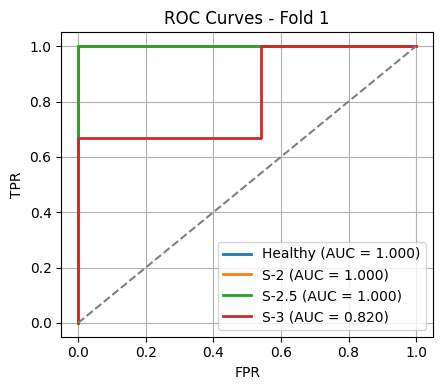

Saved in: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/roc_curves


In [5]:
plot_k_fold_roc_curves_multiclass_v2(
    fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
    tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
    auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=roc_curves_dir,
)

### MoE Model Confusion Matrices

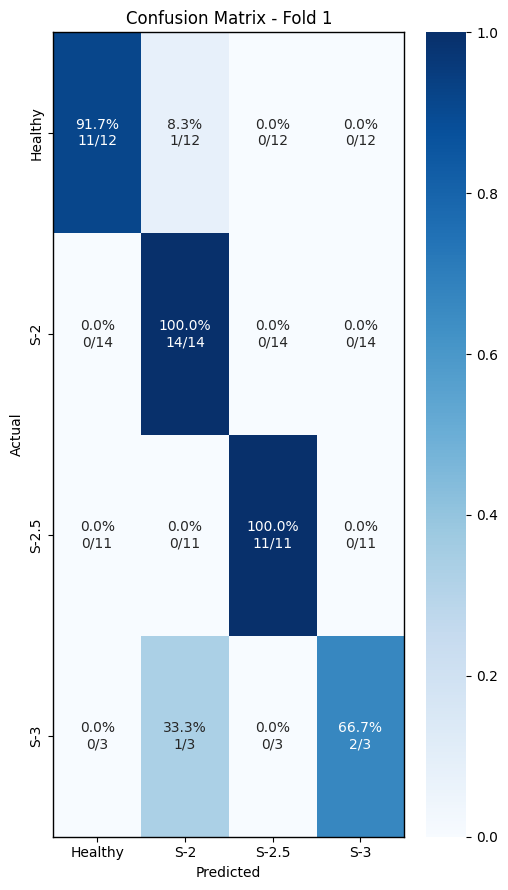

Saved in: evaluations/RNNInceptionTimeMoE_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e20/cm


In [6]:
plot_k_fold_cm(
    moe_metrics['cm']['folds'], 
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=cm_dir,
)

## Gate Model Metrics

In [7]:
print_h("GATE MODEL METRICS", 128)
save_metrics_to_json(gate_metrics, general_metrics_dir, 'gate.json')
print()
pprint(gate_metrics)

                                                       GATE MODEL METRICS                                                       

{'acc': {'avg': 0.9877966101694915, 'folds': [0.9877966101694915], 'std': 0.0},
 'cm': {'folds': [[[443, 0, 3], [6, 329, 6], [3, 0, 685]]]},
 'f1': {'avg': 0.9877685936300641, 'folds': [0.9877685936300641], 'std': 0.0},
 'precision': {'avg': 0.9879303585253013,
               'folds': [0.9879303585253013],
               'std': 0.0},
 'recall': {'avg': 0.9877966101694915,
            'folds': [0.9877966101694915],
            'std': 0.0}}


## Expert-Ga Model Metrics

In [8]:
print_h("EXPERT-Ga MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Ga'], general_metrics_dir, 'Ga.json')
print()
pprint(expert_metrics['Ga'])

                                                    EXPERT-Ga MODEL METRICS                                                     

{'acc': {'avg': 0.9375, 'folds': [0.9375], 'std': 0.0},
 'cm': {'folds': [[[5, 0, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [1, 0, 0, 1]]]},
 'f1': {'avg': 0.9299242424242424, 'folds': [0.9299242424242424], 'std': 0.0},
 'precision': {'avg': 0.9479166666666667,
               'folds': [0.9479166666666667],
               'std': 0.0},
 'recall': {'avg': 0.9375, 'folds': [0.9375], 'std': 0.0}}


## Expert-Ju Model Metrics

In [9]:
print_h("EXPERT-Ju MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Ju'], general_metrics_dir, 'Ju.json')
print()
pprint(expert_metrics['Ju'])

                                                    EXPERT-Ju MODEL METRICS                                                     

{'acc': {'avg': 0.9333333333333333, 'folds': [0.9333333333333333], 'std': 0.0},
 'cm': {'folds': [[[2, 1, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]]]},
 'f1': {'avg': 0.9303703703703704, 'folds': [0.9303703703703704], 'std': 0.0},
 'precision': {'avg': 0.9466666666666667,
               'folds': [0.9466666666666667],
               'std': 0.0},
 'recall': {'avg': 0.9333333333333333,
            'folds': [0.9333333333333333],
            'std': 0.0}}


## Expert-Si Model Metrics

In [10]:
print_h("EXPERT-Si MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Si'], general_metrics_dir, 'Si.json')
print()
pprint(expert_metrics['Si'])

                                                    EXPERT-Si MODEL METRICS                                                     

{'acc': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'cm': {'folds': [[[4, 0, 0, 0], [0, 4, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]]},
 'f1': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'precision': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'recall': {'avg': 1.0, 'folds': [1.0], 'std': 0.0}}
